# ARIMA vs SARIMA 

## IMPORT THE NECESSARY LIBRARIES

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import combinations

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
pd.options.display.float_format = '{:.2f}'.format

## IMPORT THE DATASET

In [48]:
data = pd.read_csv('AirPW.csv')
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## CHECK FOR MISSING VALUES AND BASIC INFO

In [3]:
data.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [50]:
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format = True)
data['Month'] = data['Month'].dt.to_period('M')

data['Month'] = data['Month'].astype(str)
data['Month'] = pd.to_datetime(data['Month'])

data['Date'] = pd.to_datetime(data['Month'],format='%Y-%m-%d')
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()


,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


- NO MISSING VALUES
- CONVERT THE MONTH COLUMN TO DATETIME DATATYPE AND ASSIGN IT AS INDEX 

In [6]:
#data['Date'] = pd.to_datetime(data['Month'])
#data = data.drop(columns = 'Month')
#data = data.set_index('Date')
#data = data.rename(columns = {'#Passengers':'Passengers'})
#data.head()

## FUNCTIONS FOR TIMESERIES ANALYSIS

In [7]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### DATA 

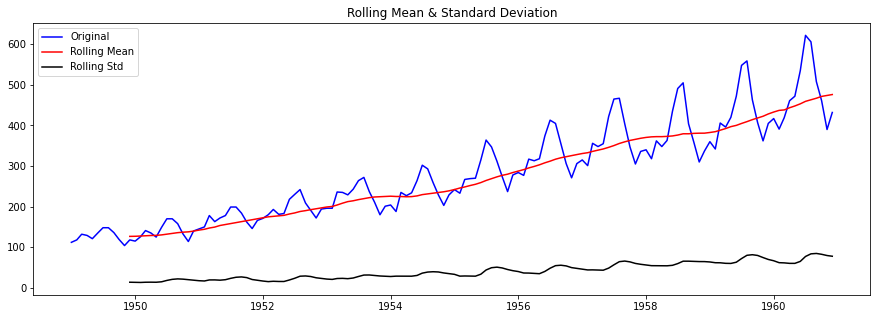

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [9]:
test_stationarity(data['Passengers'])

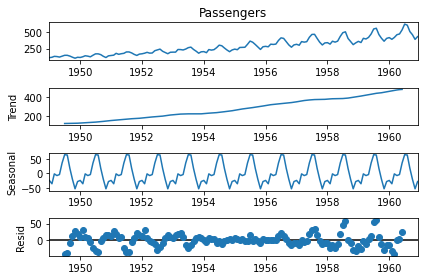

In [10]:
dec = sm.tsa.seasonal_decompose(data['Passengers'],period = 12).plot()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Passengers', ylabel='Density'>

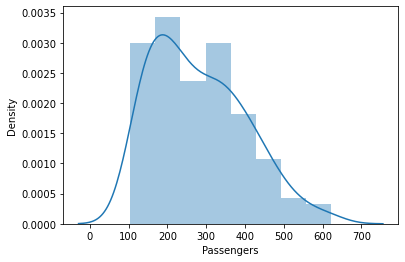

In [11]:
sns.distplot(data['Passengers'])

- DATA IS NOT STATIONARY AS THE TEST STATISTIC VALUE IS MORE THAN ANY OF THE CRITICAL VALUE
- ALSO THE P-Value IS NOT LESS THAN 0.05
- DATA HAS AN INCREASING TREND
- DATA IS ALSO SEASONAL WITH A PATTERN OF 1 YEAR

### LOG DATA

In [12]:
log_data = np.log(data)
log_data.head()

,Passengers
Date,
1949-01-01,4.72
1949-02-01,4.77
1949-03-01,4.88
1949-04-01,4.86
1949-05-01,4.80


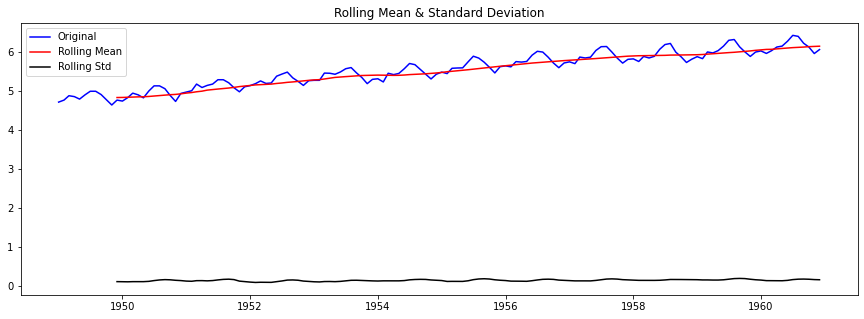

Results of Dickey-Fuller Test:
Test Statistic                 -1.72
p-value                         0.42
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [13]:
test_stationarity(log_data[ 'Passengers'])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Passengers', ylabel='Density'>

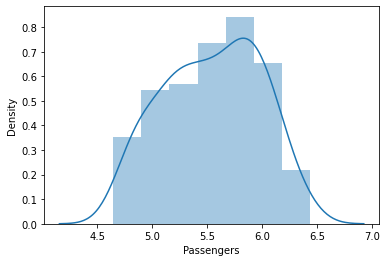

In [14]:
sns.distplot(log_data['Passengers'])

- LOG DATA ALSO HAS THE SAME ATTRIBUTES AS THAT OF DATA
- ONLY THE DATA DISTRIBUTION IS SLIGHTLY BETTER THAN PREVIOUS

## DIFFERENCING

1] DATA

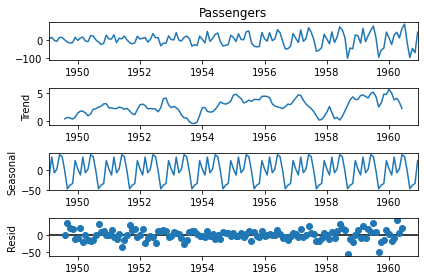

In [15]:
data_diff = data['Passengers'].diff()
data_diff = data_diff.dropna()
dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

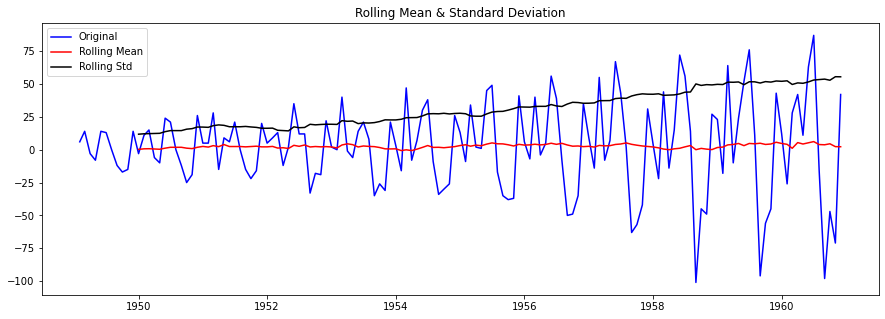

Results of Dickey-Fuller Test:
Test Statistic                 -2.83
p-value                         0.05
#Lags Used                     12.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [16]:
test_stationarity(data_diff)

- TREND HAS DIED DOWN AND IS CONSTANT
- TEST STATISTIC < CRITICAL VALUE(10%) --> DATA IS 90% SURELY STATIONARY
- P-Value = 0.05
- ROLLING IS ALSO CONSTANT
- HENCE DATA IS STATIONARY
- HOWEVER SEASONALITY IS STILL PRESENT

2] LOG DATA

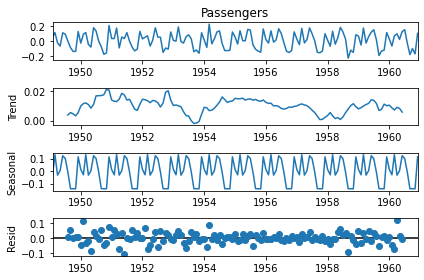

In [17]:
log_data_diff = log_data['Passengers'].diff()
log_data_diff = log_data_diff.dropna()
dec = sm.tsa.seasonal_decompose(log_data_diff,period = 12)
dec.plot()
plt.show()

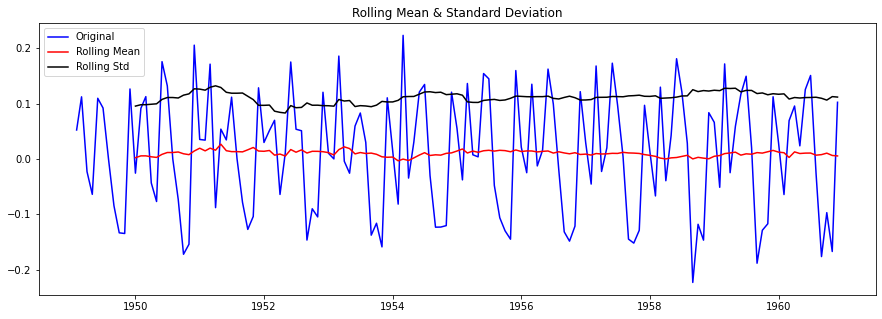

Results of Dickey-Fuller Test:
Test Statistic                 -2.72
p-value                         0.07
#Lags Used                     14.00
Number of Observations Used   128.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [18]:
test_stationarity(log_data_diff)

- TREND HAS DIED DOWN AND IS CONSTANT
- TEST STATISTIC < CRITICAL VALUE(10%) --> DATA IS 90% SURELY STATIONARY
- P-Value = 0.05
- ROLLING IS ALSO CONSTANT
- HENCE DATA IS STATIONARY
- HOWEVER SEASONALITY IS STILL PRESENT

## FROM THE ABOVE TESTS, WE CAN CHOOSE ANY OF THE DATA ABOVE FOR SELECTING THE ORDER OF SARIMA

# SARIMA [(p,d,q)x(P,D,Q,s)]

1] DATA

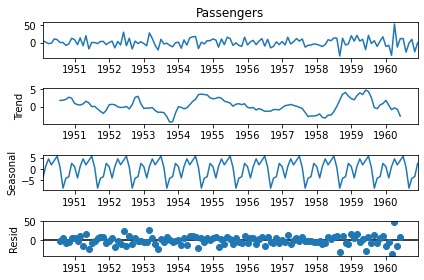

In [19]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

- SEASONAL DIFFERENCE WITH A SEASONAL PERIOD(s) OF 12
- SINCE OUR DATA IS MONTHLY DATA AND FROM THE PLOTS,WE OBSERVE THAT A YEARLY PATTERN IS PRESENT
- WE USE THIS OPERATION ON THE PREVIOUSLY DIFFERENCED DATA SO THAT WE DO  NOT HAVE TO DEAL WITH TREND & STATIONARITY AGAIN

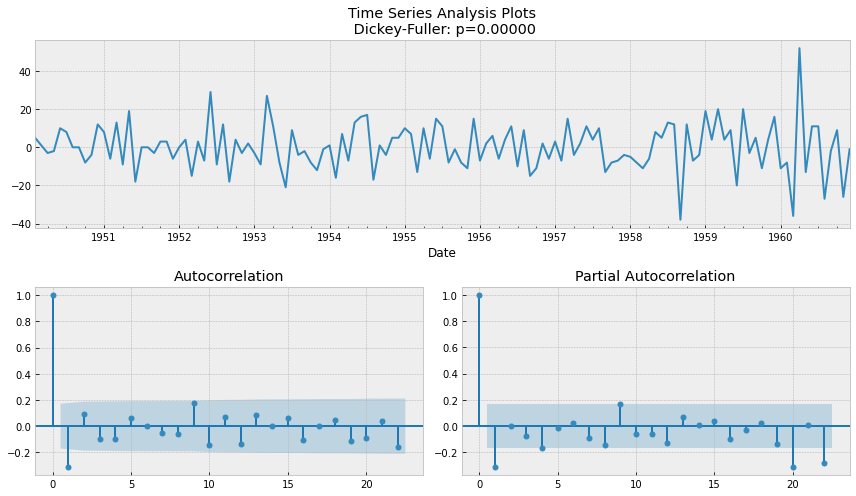

In [20]:
tsplot(data_diff_seas)

- SARIMA MODEL ORDER [(p,d,q)x(P,D,Q,s)]
- (p,d,q) = THIS ORDER IS INHERITED FROM OUR ABOVE ARIMA MODEL
- (P,D,Q,s) = THIS IS ORDER IS SELECTED USING THE SAME TECHNIQUE USED FOR ARIMA
- s = SEASONAL ORDER = ONLY ADDITIONAL PARAMETER 
- WE AGAIN SELECT THE MODEL WITH LEAST AIC SCORE

In [21]:
model = sm.tsa.statespace.SARIMAX(data['Passengers'],order = (2,1,2),seasonal_order = (1,1,2,12))
results = model.fit()
print(results.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51684D+00    |proj g|=  9.17899D-02


 This problem is unconstrained.



At iterate    5    f=  3.50599D+00    |proj g|=  1.13879D-02

At iterate   10    f=  3.50179D+00    |proj g|=  9.12514D-03

At iterate   15    f=  3.49420D+00    |proj g|=  9.01407D-03

At iterate   20    f=  3.49288D+00    |proj g|=  4.89332D-03

At iterate   25    f=  3.49256D+00    |proj g|=  2.65990D-03

At iterate   30    f=  3.47276D+00    |proj g|=  2.77433D-02

At iterate   35    f=  3.46708D+00    |proj g|=  5.14822D-03

At iterate   40    f=  3.46539D+00    |proj g|=  8.39646D-04

At iterate   45    f=  3.46530D+00    |proj g|=  2.32677D-03

At iterate   50    f=  3.46524D+00    |proj g|=  1.96666D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -498.994
Date:                            Sun, 26 Sep 2021   AIC                           1013.988
Time:                                    07:48:33   BIC                           1036.989
Sample:                                01-01-1949   HQIC                          1023.334
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6119      0.384      1.595      0.111      -0.140       1.364
ar.L2          0.2192      0.249   

<AxesSubplot:xlabel='Date'>

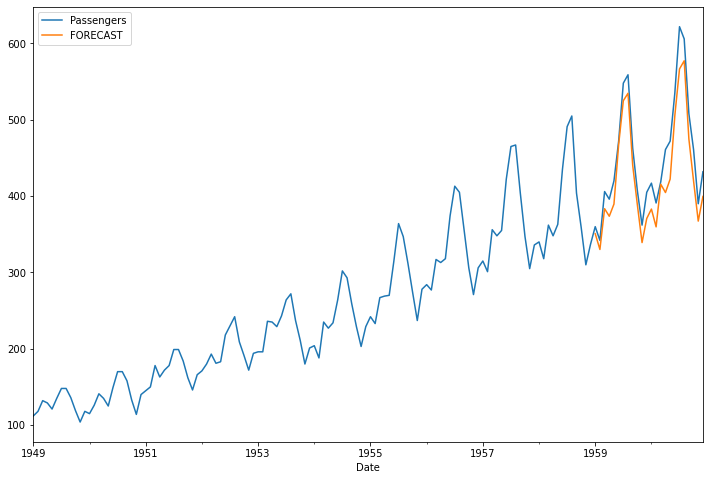

In [28]:
#data = data.reset_index()

data['FORECAST'] = results.predict(start = 120,end = 144,dynamic = True)
data[['Passengers','FORECAST']].plot(figsize = (12,8))

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Passengers  144 non-null    int64  
 1   FORECAST    24 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 3.4 KB


In [30]:
np.any(np.isnan(data))
np.all(np.isfinite(data))


False

In [31]:
exp = [data.iloc[i,0] for i in range(120,len(data))]
pred = [data.iloc[i,1] for i in range(120,len(data))]
print(mean_absolute_error(exp,pred))

27.662716979860505


In [32]:
def mean_absolute_percentage_error(exp, pred): 
    return np.mean(np.abs((exp - pred) /np.abs(exp))) * 100
print('Mean absolute percentage error: ',mean_absolute_percentage_error(data.Passengers,data.FORECAST))


Mean absolute percentage error:  6.073880840287297


In [33]:
data = data.drop(columns = 'FORECAST')

- PREDICTED PLOTS ARE GREAT 
- ERROR HAS ALSO REDUCED ALOT
- HENCE WE ACCEPT THIS MODEL AND FORECAST FOR 2 MORE YEARS

# FORECASTING

### ADD DATES TO OUR DATAFRAME FOR OUR FORECASTING PURPOSE

In [57]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(months = x)for x in range(0,37)]
df = pd.DataFrame(index = future_dates[1:],columns = data.columns)

In [34]:
start_index = '1961-01-01'
end_index = '1963-12-01'
forecast = results.predict(start=start_index, end=end_index)
#forecast = forecast.astype(str)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [35]:
test = pd.read_csv('Test2.csv')
test.head()

,Month
0,1961-01-01
1,1961-02-01
2,1961-03-01
3,1961-04-01
4,1961-05-01


In [36]:
test = test.set_index(forecast.index)


In [37]:
test['Passengers'] = forecast
test.head()

,Month,Passengers
1961-01-01,1961-01-01,447.77
1961-02-01,1961-02-01,420.76
1961-03-01,1961-03-01,463.17
1961-04-01,1961-04-01,488.67
1961-05-01,1961-05-01,505.92


In [38]:
test['Passengers'] = test['Passengers'].round(decimals = 0)


In [39]:
test['Passengers'] = test['Passengers'].astype(int)

In [40]:
test['Passengers'].head()

1961-01-01    448
1961-02-01    421
1961-03-01    463
1961-04-01    489
1961-05-01    506
Freq: MS, Name: Passengers, dtype: int64

In [41]:
test.to_csv('Predictions.csv', header=True, index=False)

## FINAL PLOT

<AxesSubplot:>

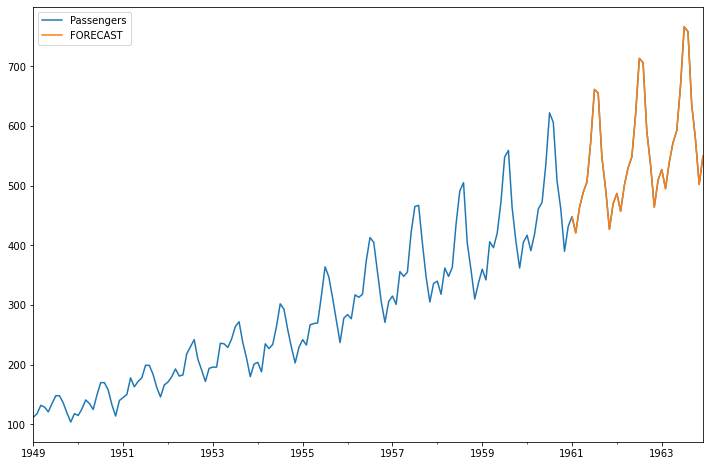

In [44]:
forecast = pd.concat([data,test])
forecast['FORECAST'] = results.predict(start = 144,end = 300,dynamic = True)
forecast[['Passengers','FORECAST']].plot(figsize = (12,8))